In [1]:
import os
# import drjit
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [2]:
# common parameters
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = None
model_parameters["num_silent_pilot_symbols"] = 0
jammer_parameters["trainable"] = True
model_parameters["jammer_parameters"] = jammer_parameters
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)

sim.BATCH_SIZE = 8
sim.MAX_MC_ITER = 250

def experiment(num_ut):
    jammer_powers_db = [-5, 0, 5, 10]
    for jammer_power_db in jammer_powers_db:
        model = Model(**model_parameters, num_ut=num_ut, jammer_power=db_to_linear(jammer_power_db))
        # barrage simulation
        simulate_model(model, f"Barrage, {num_ut} UEs, {jammer_power_db}dB")
        # learned weights
        load_weights(model, f"weights/unmitigated/symbol/ue_{num_ut}_pow_{jammer_power_db}dB.pickle")
        simulate_model(model, f"Learned, {num_ut} UEs, {jammer_power_db}dB")

In [3]:
experiment(1)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 7.2336e-02 | 1.0000e+00 |     1925879 |    26624000 |         8000 |        8000 |        61.8 |reached max iter       
   -3.667 | 4.5566e-02 | 1.0000e+00 |     1213160 |    26624000 |         8000 |        8000 |        47.2 |reached max iter       
   -2.333 | 2.8320e-02 | 1.0000e+00 |      753981 |    26624000 |         8000 |        8000 |        47.8 |reached max iter       
     -1.0 | 1.8433e-02 | 1.0000e+00 |      490756 |    26624000 |         8000 |        8000 |        48.9 |reached max iter       
    0.333 | 1.2683e-02 | 1.0000e+00 |      337671 |    26624000 |         8000 |        8000 |        49.5 |reached max iter       
    1.667 | 9.4036e-03 | 9.9962e-01 |      250362 |    26624000 |         7997 |     

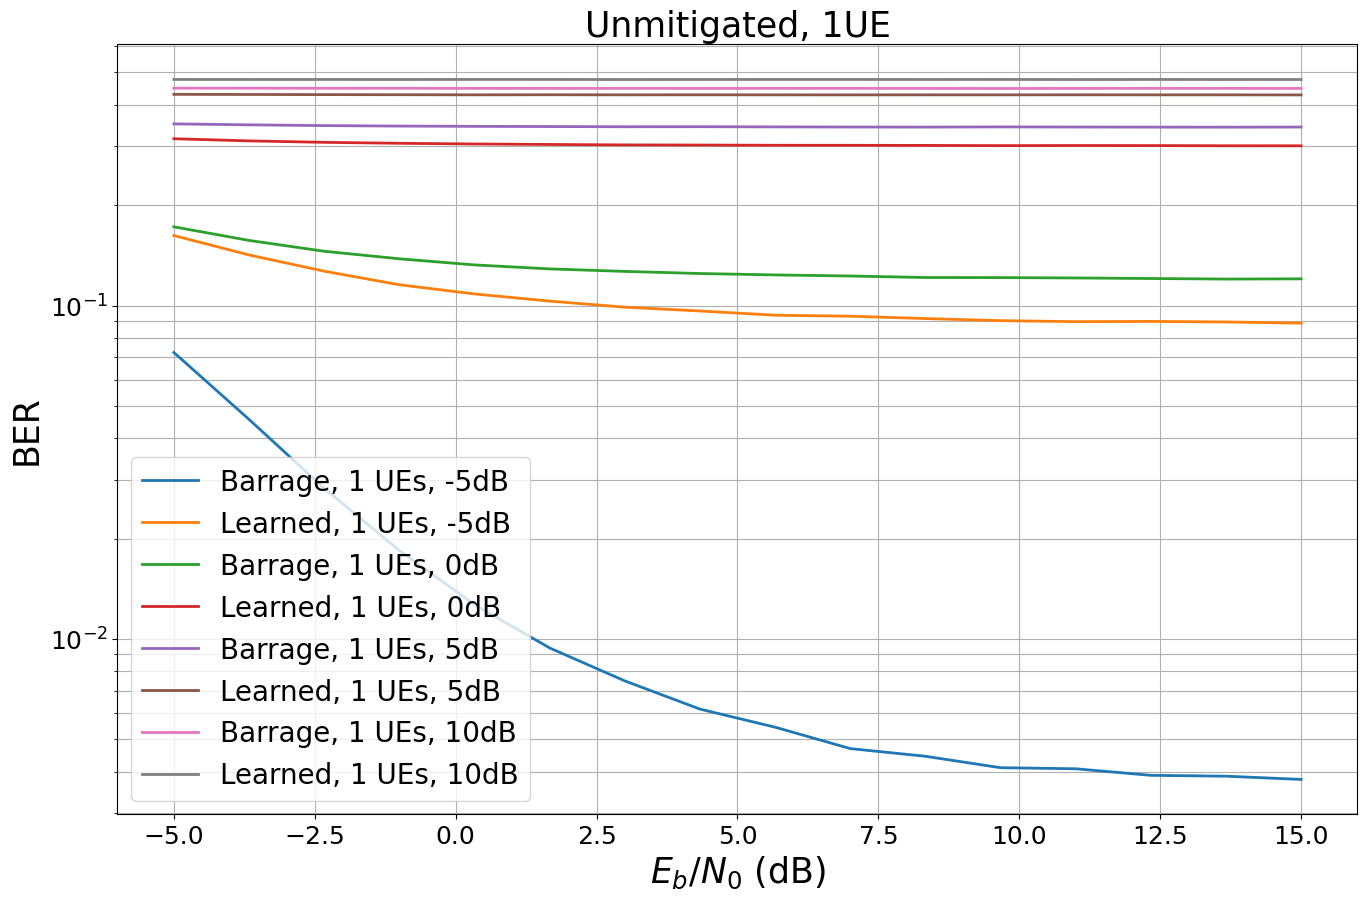

In [4]:
ber_plots.title = "Unmitigated, 1UE"
ber_plots()

In order to find out how many dB we gain by training, we ran an experiment plotting barrage jammers at 0.25dB resolution. In the following plot, we show learned jammers with the most similar barrage jammer

In [8]:
ber_plots.reset()
jammer_powers_db = [-5, 0, 5, 10]
equivalent_jammer_powers = [-2.5, 3.75, 8.5, 14.0]
for jammer_power_db, equivalent in zip(jammer_powers_db, equivalent_jammer_powers):
    # barrage simulation
    model = Model(**model_parameters, num_ut=1, jammer_power=db_to_linear(equivalent))
    simulate_model(model, f"Barrage, {equivalent}dB")
    # learned weights
    model = Model(**model_parameters, num_ut=1, jammer_power=db_to_linear(jammer_power_db))
    load_weights(model, f"weights/unmitigated/symbol/ue_1_pow_{jammer_power_db}dB.pickle")
    simulate_model(model, f"Learned, {jammer_power_db}dB")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 1.1367e-01 | 1.0000e+00 |      756617 |     6656000 |         2000 |        2000 |        20.7 |reached max iter       
   -3.667 | 9.0341e-02 | 1.0000e+00 |      601307 |     6656000 |         2000 |        2000 |        11.2 |reached max iter       
   -2.333 | 7.4784e-02 | 1.0000e+00 |      497765 |     6656000 |         2000 |        2000 |        11.3 |reached max iter       
     -1.0 | 6.3636e-02 | 1.0000e+00 |      423563 |     6656000 |         2000 |        2000 |        11.2 |reached max iter       
    0.333 | 5.5485e-02 | 1.0000e+00 |      369310 |     6656000 |         2000 |        2000 |        11.2 |reached max iter       
    1.667 | 5.0974e-02 | 1.0000e+00 |      339280 |     6656000 |         2000 |     

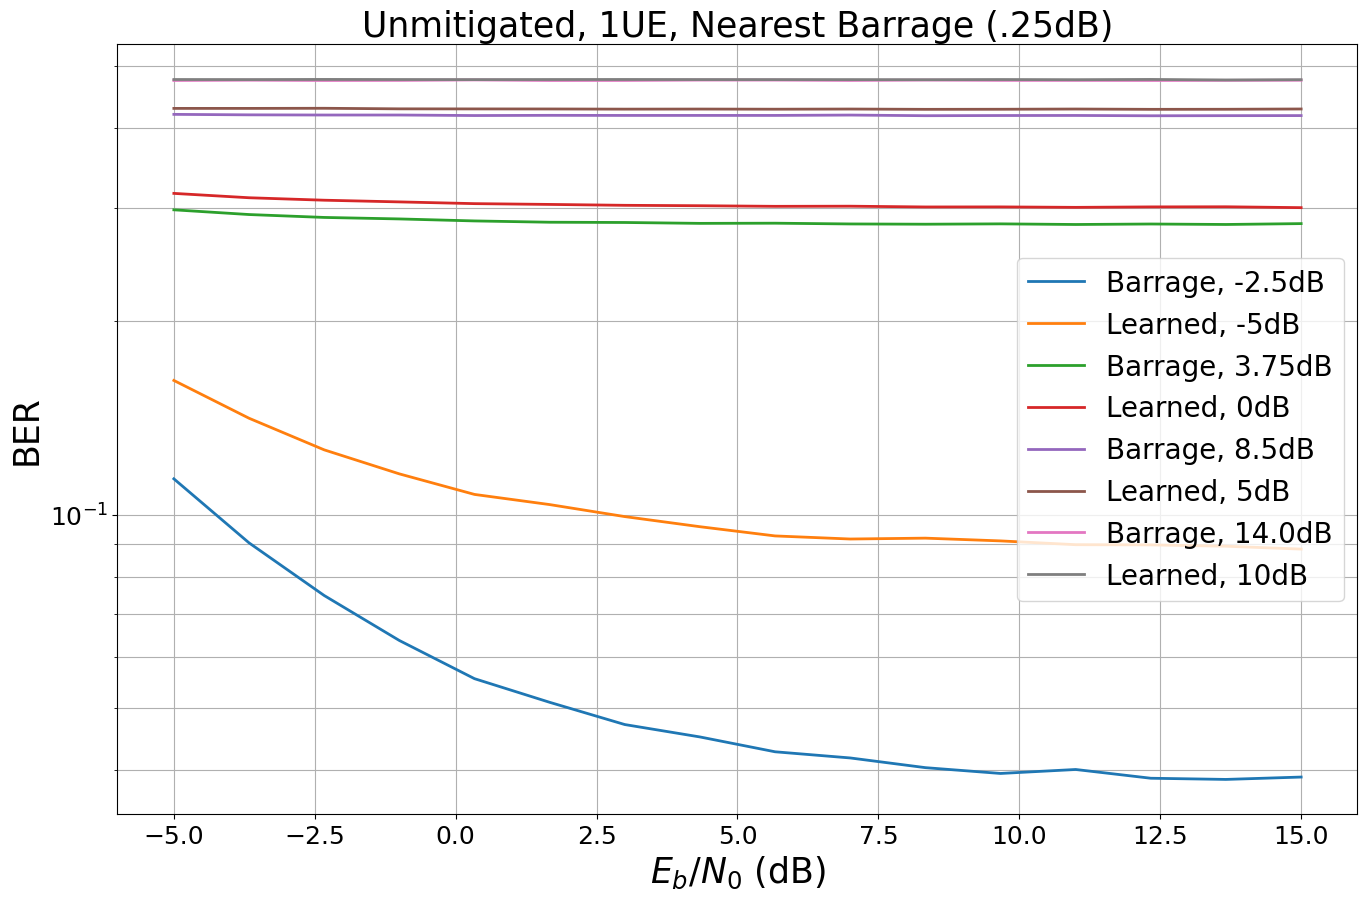

In [9]:
ber_plots.title = "Unmitigated, 1UE, Nearest Barrage (.25dB)"
ber_plots()

In [3]:
ber_plots.reset()
experiment(4)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.2041e-02 | 1.0000e+00 |      860991 |    20480000 |         2000 |        2000 |        27.4 |reached max iter       
   -3.667 | 2.5404e-02 | 1.0000e+00 |      520273 |    20480000 |         2000 |        2000 |        11.6 |reached max iter       
   -2.333 | 1.5452e-02 | 1.0000e+00 |      316465 |    20480000 |         2000 |        2000 |        11.3 |reached max iter       
     -1.0 | 9.4354e-03 | 1.0000e+00 |      193236 |    20480000 |         2000 |        2000 |        11.2 |reached max iter       
    0.333 | 6.5275e-03 | 1.0000e+00 |      133683 |    20480000 |         2000 |        2000 |        11.2 |reached max iter       
    1.667 | 4.6332e-03 | 1.0000e+00 |       94888 |    20480000 |         2000 |     

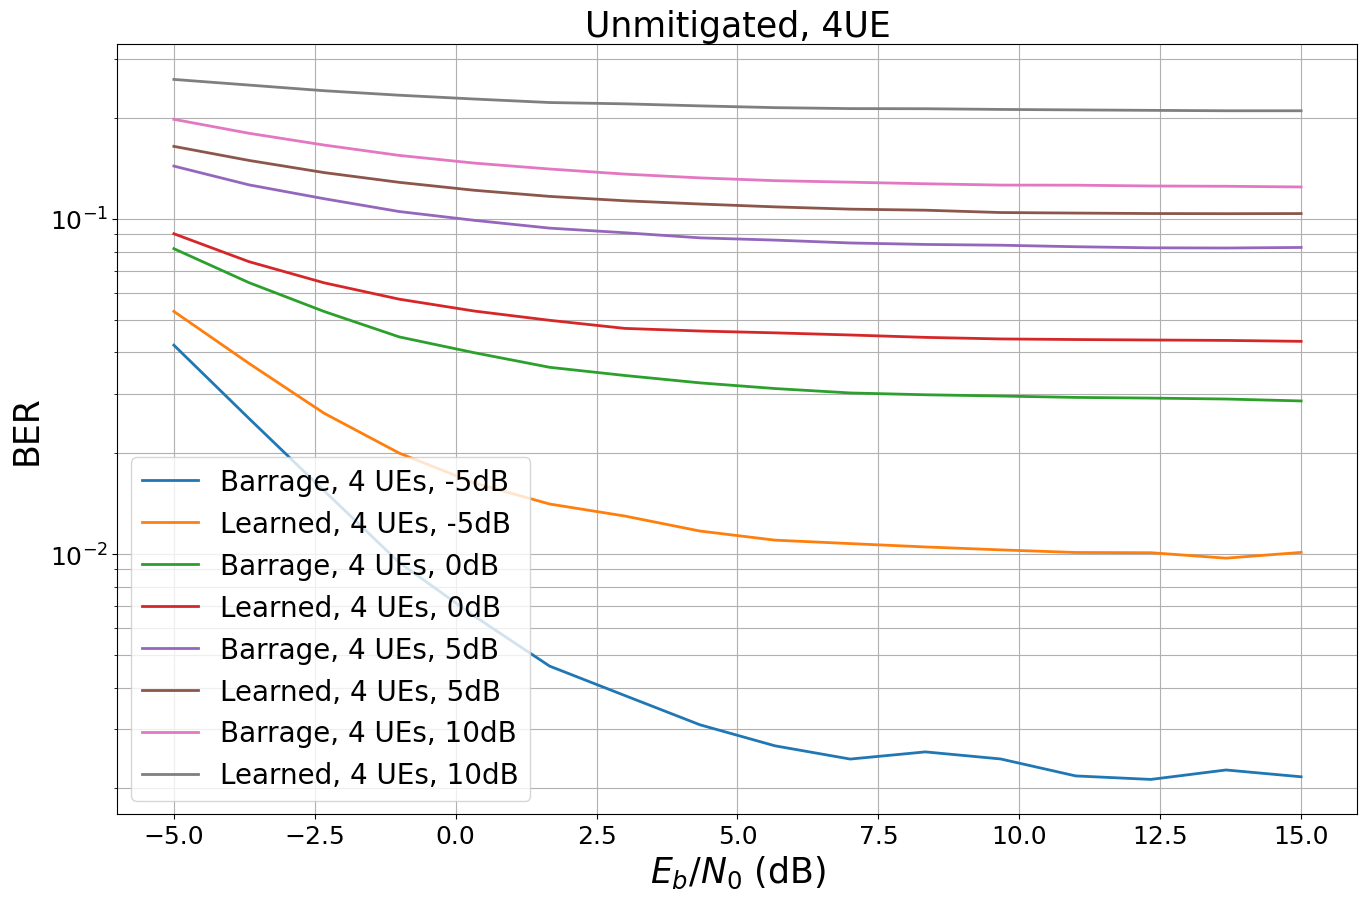

In [4]:
ber_plots.title = "Unmitigated, 4UE"
ber_plots()

In order to find out how many dB we gain by training, we ran an experiment plotting barrage jammers at 0.25dB resolution. In the following plot, we show learned jammers with the most similar barrage jammer. A 10dB learned jammer is virtually impossible to match until we reach numerically instable simulations (~50dB).

In [3]:
ber_plots.reset()
jammer_powers_db = [-5, 0, 5, 10]
equivalent_jammer_powers = [-2.5, 1.5, 7.5, 30.0]
for jammer_power_db, equivalent in zip(jammer_powers_db, equivalent_jammer_powers):
    # barrage simulation
    model = Model(**model_parameters, num_ut=4, jammer_power=db_to_linear(equivalent))
    simulate_model(model, f"Barrage, {equivalent}dB")
    # learned weights
    model = Model(**model_parameters, num_ut=4, jammer_power=db_to_linear(jammer_power_db))
    load_weights(model, f"weights/unmitigated/symbol/ue_4_pow_{jammer_power_db}dB.pickle")
    simulate_model(model, f"Learned, {jammer_power_db}dB")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 5.5339e-02 | 1.0000e+00 |     1133349 |    20480000 |         2000 |        2000 |        27.8 |reached max iter       
   -3.667 | 3.8951e-02 | 1.0000e+00 |      797722 |    20480000 |         2000 |        2000 |        12.0 |reached max iter       
   -2.333 | 2.7640e-02 | 1.0000e+00 |      566074 |    20480000 |         2000 |        2000 |        11.9 |reached max iter       
     -1.0 | 2.0776e-02 | 1.0000e+00 |      425484 |    20480000 |         2000 |        2000 |        11.9 |reached max iter       
    0.333 | 1.6528e-02 | 1.0000e+00 |      338490 |    20480000 |         2000 |        2000 |        11.9 |reached max iter       
    1.667 | 1.3977e-02 | 1.0000e+00 |      286245 |    20480000 |         2000 |     

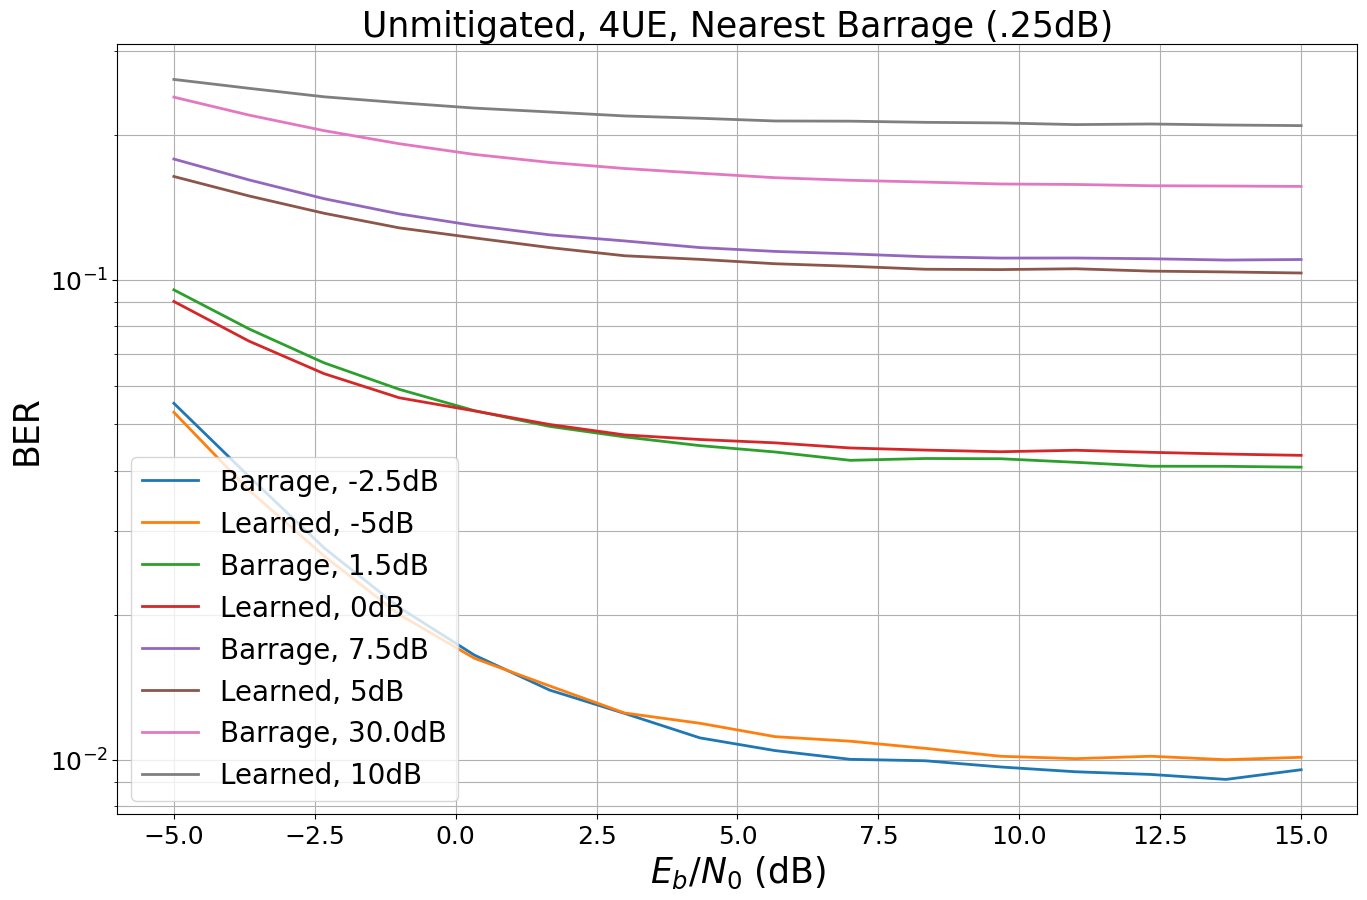

In [4]:
ber_plots.title = "Unmitigated, 4UE, Nearest Barrage (.25dB)"
ber_plots()